# Libraries

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score, classification_report, f1_score
from afinn import Afinn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier, XGBRegressor  # 按需选择回归或分类模型
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Loading the Files

Download the csv files into the `data/` directory.

Null values in each column after processing:
Id                             0
ProductId                      0
UserId                         0
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Time                           0
Summary                        0
Text                           0
Score                     212192
dtype: int64
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348

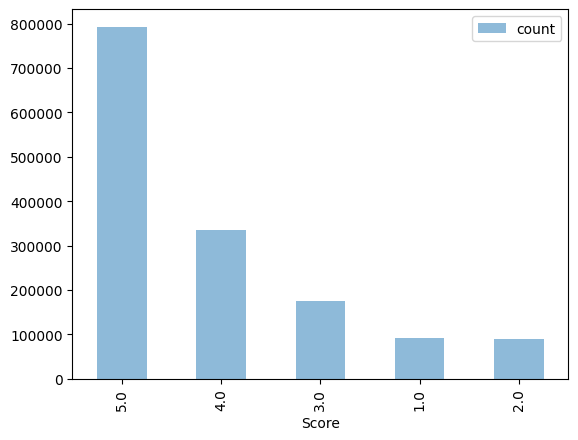


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
dtype_spec = {
    'ProductId': 'str',
    'UserId': 'str',
    'HelpfulnessNumerator': 'int32',
    'HelpfulnessDenominator': 'int32',
    'Score': 'float32',  
    'Time': 'int64',  
    'Summary': 'str',
    'Text': 'str',
    'Id': 'str'
}

trainingSet = pd.read_csv("./data/train.csv", dtype=dtype_spec)
testingSet = pd.read_csv("./data/test.csv", dtype=dtype_spec)

trainingSet['HelpfulnessNumerator'] = trainingSet['HelpfulnessNumerator'].fillna(0)
trainingSet['HelpfulnessDenominator'] = trainingSet['HelpfulnessDenominator'].fillna(0)
trainingSet['Text'] = trainingSet['Text'].fillna("")
trainingSet['Summary'] = trainingSet['Summary'].fillna("")

if trainingSet['Time'].isnull().sum() > 0:
    median_time = trainingSet['Time'].median()
    trainingSet['Time'] = trainingSet['Time'].fillna(median_time)

print("Null values in each column after processing:")
print(trainingSet.isnull().sum())

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [4]:
afinn = Afinn()
def sentiment_analysis(text):
    # compute the text score
    score = afinn.score(text)
    return score 

def batch_sentiment_analysis(texts):
    return [afinn.score(text) for text in texts]

def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year

    df['TextLength'] = df['Text'].apply(len)
    df['SummaryLength'] = df['Summary'].apply(len)

    chunk_size = 100000  
    sentiment_scores = []
    for i in range(0, len(df), chunk_size):
        chunk_texts = df['Text'].iloc[i:i + chunk_size]
        sentiment_scores += batch_sentiment_analysis(chunk_texts)
    df['SentimentScore'] = sentiment_scores

    user_avg_score = df.groupby('UserId')['Score'].transform('mean')
    product_avg_score = df.groupby('ProductId')['Score'].transform('mean')
    product_review_count = df.groupby('ProductId')['Score'].transform('count')

    df['UserAverageScore'] = user_avg_score
    df['ProductAverageScore'] = product_avg_score
    df['ProductReviewCount'] = product_review_count

    df['HelpfulnessNumerator'] = df['HelpfulnessNumerator'].astype('int32')
    df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].astype('int32')
    df['Year'] = df['Year'].astype('int32')
    df['TextLength'] = df['TextLength'].astype('int32')
    df['SummaryLength'] = df['SummaryLength'].astype('int32')

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [5]:
#create a sample for testing first
sample_df = X_train.sample(frac=0.1, random_state=42)
X_sample = sample_df.drop(columns=['Score']) 
y_sample = sample_df['Score']  
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

X = X_train.drop(columns=['Score'])  
y = X_train['Score']  
X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train_split.shape)
print("Validation set size:", X_val.shape)
print("Training labels size:", y_train_split.shape)
print("Validation labels size:", y_val.shape)

Training set size: (1188272, 16)
Validation set size: (297069, 16)
Training labels size: (1188272,)
Validation labels size: (297069,)


# Feature Selection

In [6]:
features = [
    'Helpfulness',          
    'SentimentScore',        
    'TextLength',             
    'UserAverageScore',     
    'ProductAverageScore',   
    'ProductReviewCount',                   
]

X_train_sample_selected = X_train_sample[features]
X_val_sample_selected = X_val_sample[features]

X_train_selected = X_train_split[features]
X_val_selected = X_val[features]

X_submission_select = X_submission[features]
imputer = SimpleImputer(strategy='mean')
X_submission_select = imputer.fit_transform(X_submission_select)

print("Any NaN values in X_submission_select:", np.isnan(X_submission_select).any())

Any NaN values in X_submission_select: False


In [8]:
print(X_train_selected.dtypes)
print(y_train_split.dtypes)

Helpfulness            float64
SentimentScore         float64
TextLength               int64
UserAverageScore       float64
ProductAverageScore    float64
ProductReviewCount       int64
dtype: object
float64


# Model Creation

## Random Forest

In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

rf_model.fit(X_train_sample_selected, y_train_sample)

y_val_pred = rf_model.predict(X_val_sample_selected)

print("Classification Report:\n", classification_report(y_val_sample, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val_sample, y_val_pred))

Classification Report:
               precision    recall  f1-score   support

         1.0       0.54      0.55      0.54      1908
         2.0       0.26      0.15      0.19      1723
         3.0       0.31      0.22      0.26      3525
         4.0       0.37      0.29      0.33      6711
         5.0       0.71      0.86      0.78     15840

    accuracy                           0.59     29707
   macro avg       0.44      0.41      0.42     29707
weighted avg       0.55      0.59      0.57     29707

Confusion Matrix:
 [[ 1040   246   257   169   196]
 [  397   261   434   323   308]
 [  267   257   792  1070  1139]
 [  143   164   642  1949  3813]
 [   96    89   413  1691 13551]]


In [10]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')

grid_search.fit(X_train_sample_selected, y_train_sample)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

rf_model = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')
rf_model.fit(X_train_selected, y_train_split)


/Users/weixin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/weixin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/weixin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/weixin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constrain

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

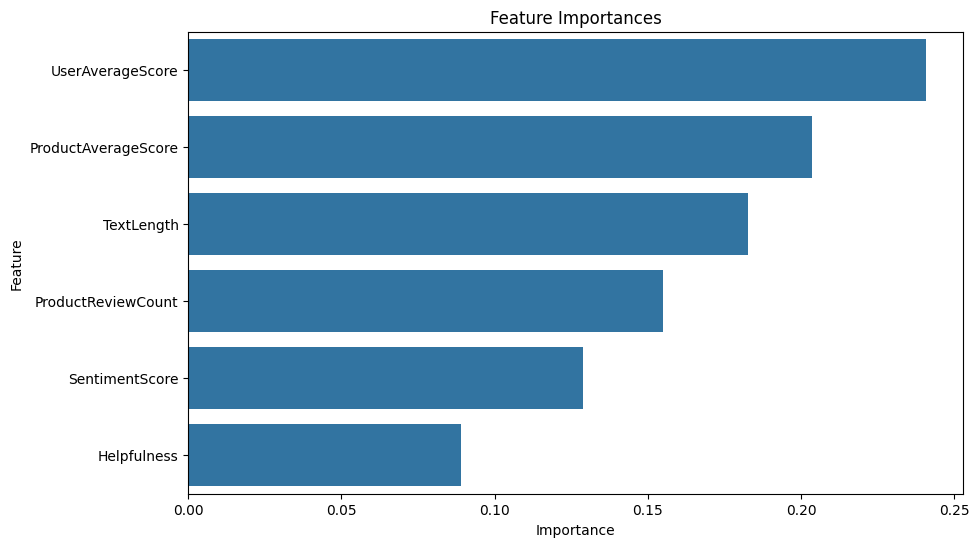

In [11]:
feature_importances = rf_model.feature_importances_
feature_names = X_train_selected.columns

feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances)
plt.title('Feature Importances')
plt.show()

# Create submission file

In [12]:
# Create the submission file
y_test_pred = rf_model.predict(X_submission_select)

y_test_pred_rounded = np.clip(np.round(y_test_pred), 1, 5)

X_submission['Score'] = y_test_pred_rounded
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

/Users/weixin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
